## Setup

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import data

In [2]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [3]:
ds_static = xr.open_dataset(luh2_static_file)
ds_target = xr.open_dataset(regrid_target_file)
ds_clmsurf = xr.open_dataset(clm_surface_file)
ds_forest = xr.open_dataset(clm_forest_file)
ds_pasture = xr.open_dataset(clm_pasture_file)
ds_other = xr.open_dataset(clm_other_file)

## Prep data

### Target dataset

Rename and add lat/lon as dimensions/coordinates

In [4]:
# Rename the lat/lon dimensions
ds_target = ds_target.rename_dims(dims_dict={'lsmlat':'lat','lsmlon':'lon'})

# Add lat/lon as a coordinate (note that the default longitude is 0:360)
ds_target['lon'] = ds_target.LONGXY.isel(lat=0)
ds_target['lat'] = ds_target.LATIXY.isel(lon=0)

# Convert longitude to -180:180 to match all other datasets (I don't think this is strictly necessary)
# ds_target['lon'] = np.mod((ds_target.lon + 180.), 360.) - 180.

Mask the data using the `PCT_NATVEG`

In [5]:
# Note that this results in a T/F mask, not a 1/0 mask.  I'm not sure this matters.
ds_target["mask"] = ds_target.PCT_NATVEG > 0.

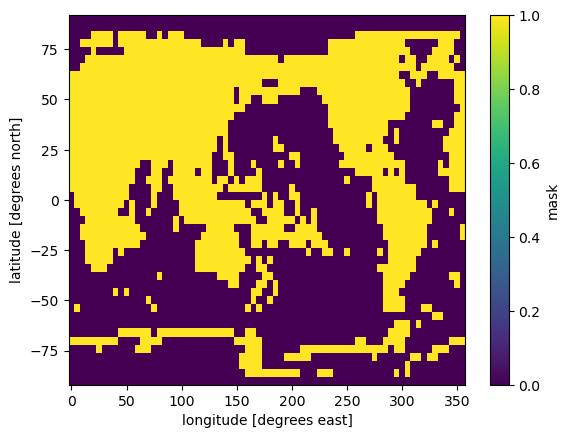

In [6]:
ds_target.mask.plot()

### CLM5 Surface dataset

Create a lat/lon coordinate from the LAT/LON variable

In [7]:
# The lat/lon dimensions exist, but are simply indices, not degree valued (i.e. 0, 1, 2, etc)
ds_clmsurf['lat'] = ds_clmsurf.LAT
ds_clmsurf['lon'] = ds_clmsurf.LON

Compute a mask for the other CLM5 landuse-pft data

In [8]:
# Confirm that addition is equivalent to logical_and
(np.logical_or(ds_clmsurf.PCT_NATVEG > 0.,ds_static.icwtr != 1.) == (ds_clmsurf.PCT_NATVEG > 0.) + (ds_static.icwtr != 1.)).all()

<xarray.DataArray ()>
array(True)

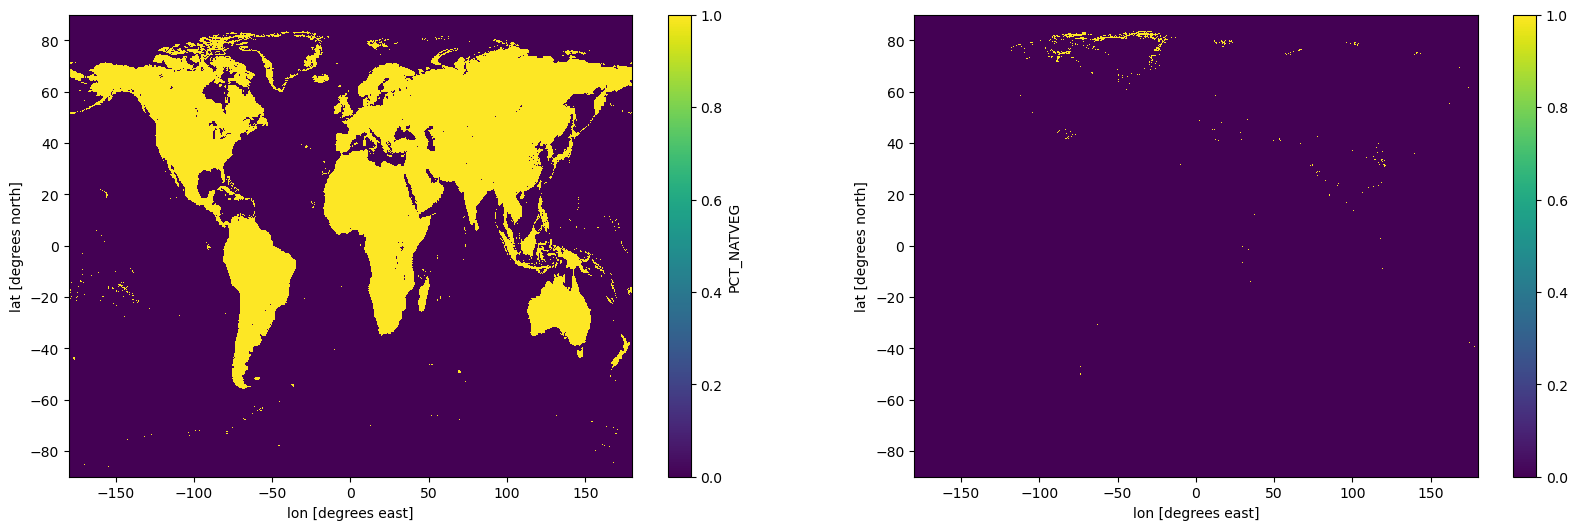

In [9]:
# Including the icwtr mask here results in some null patterning interior to the continents.
# Note that in joinging (adding) the two masks, the difference will only show as positives (even if converted to 1/0)
mask_clmsurf_natvegonly = ds_clmsurf.PCT_NATVEG > 0.
mask_clmsurf_natveg_icwtr = mask_clmsurf_natvegonly + (ds_static.icwtr != 1.)
f,ax = plt.subplots(1,2,figsize=(20,6))
mask_clmsurf_natvegonly.plot(ax=ax[0])
(np.logical_xor(mask_clmsurf_natveg_icwtr,mask_clmsurf_natvegonly)).plot(ax=ax[1])

### CLM5 forest data

Create a lat/lon coordinate from the LAT/LON variable (as with the other clm5 landuse pft data)

In [10]:
ds_forest['lat'] = ds_forest.LAT
ds_forest['lon'] = ds_forest.LON

### CLM5 pasture data

Create a lat/lon coordinate from the LAT/LON variable (as with the other clm5 landuse pft data)

In [11]:
ds_pasture['lat'] = ds_pasture.LAT
ds_pasture['lon'] = ds_pasture.LON

### CLM5 other data

Create a lat/lon coordinate from the LAT/LON variable (as with the other clm5 landuse pft data)

In [12]:
ds_other['lat'] = ds_other.LAT
ds_other['lon'] = ds_other.LON

## Normalize the `PCT_NAT_PFT` data

Remove the bareground PFT and renormalize the percentages against the sum of the non-bareground total

### Forest

In [13]:
percent_forest = ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None))
percent_forest = percent_forest / percent_forest.sum(dim='natpft')

Add the mask from the clm5 surface dataset

In [14]:
ds_percent_forest = percent_forest.to_dataset()
ds_percent_forest_copy = ds_percent_forest.copy(deep=True)
ds_percent_forest['mask'] = mask_clmsurf_natveg_icwtr
ds_percent_forest_copy['mask'] = mask_clmsurf_natvegonly

### Pasture

In [15]:
percent_pasture = ds_pasture.PCT_NAT_PFT.isel(natpft=slice(1,None))
percent_pasture = percent_pasture / percent_pasture.sum(dim='natpft')

Add the mask from the clm5 surface dataset

In [16]:
ds_percent_pasture = percent_pasture.to_dataset()
ds_percent_pasture_copy = ds_percent_pasture.copy(deep=True)
ds_percent_pasture['mask'] = mask_clmsurf_natveg_icwtr
ds_percent_pasture_copy['mask'] = mask_clmsurf_natvegonly

### Range

In [17]:
percent_range = ds_other.PCT_NAT_PFT.isel(natpft=slice(1,None))
percent_range = percent_range / percent_range.sum(dim='natpft')

Add the mask from the clm5 surface dataset

In [18]:
ds_percent_range = percent_range.to_dataset()
ds_percent_range['mask'] = mask_clmsurf_natveg_icwtr

## Calculate the primary + secondary forest percentage

In [19]:
# Note that the order of the calculation matters and affects the dimension ordering
# The 'percent' array needs to come first to keep natpft first.  I think the convention it follows is the first array in the calculation sets the order precidence.
# So setting ds_static first, with its lack of natpft, would set lan/lon first.
# Overall I'm not sure how much this matters in reality, but xESMF does state the lat/lon should be last.
percent_primary_secondary =  (percent_forest * ds_static.fstnf) + (percent_range * (1. - ds_static.fstnf))
percent_primary_secondary_old = (ds_static.fstnf* percent_forest) + ((1. - ds_static.fstnf) * percent_range)

In [20]:
((percent_primary_secondary_old.sum(dim='natpft') > 0) == (percent_primary_secondary.sum(dim='natpft') > 0)).all().data

array(True)

**Question:** this has the bareground removed from both percentage sets and they have been normalize; does the masking cover both here?  Or is there data missing from either that is not inclusive of the clm surface data?

In [22]:
# For now just pass the forest name, which should be the same for all percentage data arrays since they only consist of `PCT_NAT_PFT`
ds_percent_primary_secondary = percent_primary_secondary.to_dataset(name=percent_forest.name)
ds_percent_primary_secondary_copy = ds_percent_primary_secondary.copy(deep=True)
ds_percent_primary_secondary['mask'] = mask_clmsurf_natveg_icwtr
ds_percent_primary_secondary_copy['mask'] = mask_clmsurf_natvegonly

## Regrid the data

### Pasture

In [23]:
regrid_method = 'conservative_normed'
# regrid_method = 'conservative'   # This results in the coastline data being less than 1.0 for the sum of all `pct_nat_pft`

In [24]:
regridder = xe.Regridder(ds_percent_pasture,ds_target,regrid_method)
ds_regrid = regridder(ds_percent_pasture)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Text(0.5, 0.98, 'Input mask INCLUDING icwtr')

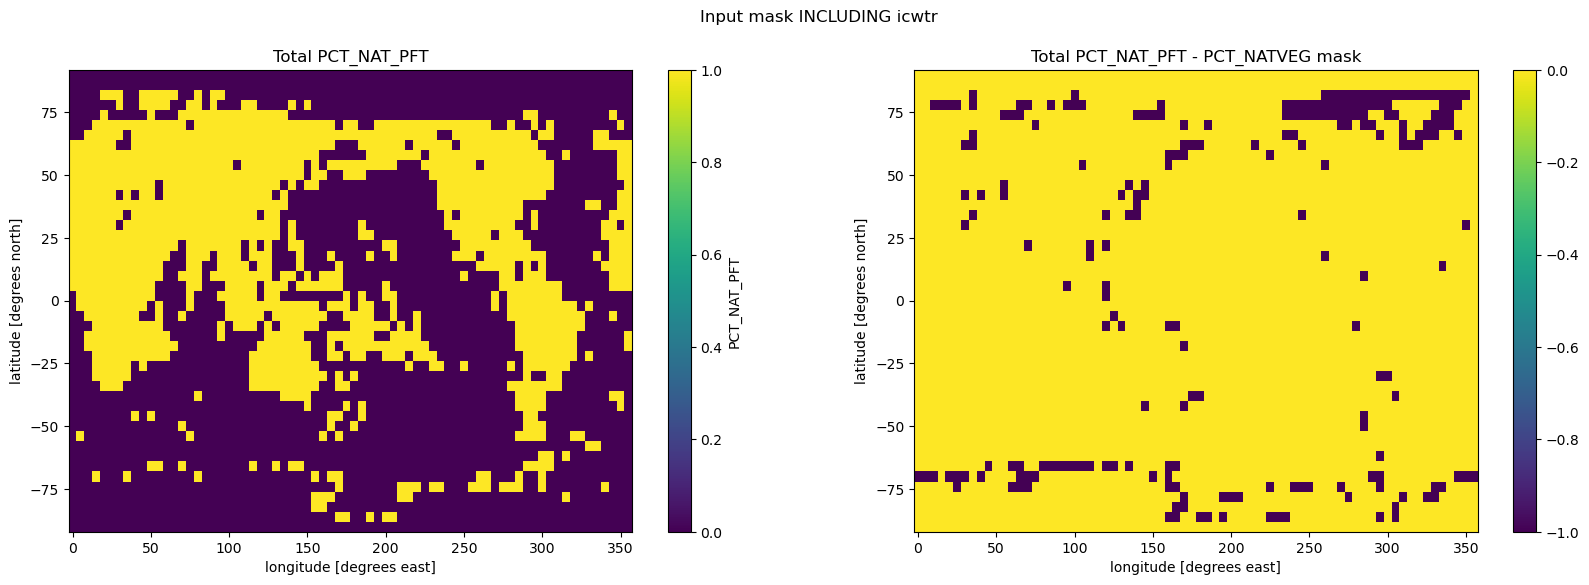

In [25]:
f,ax = plt.subplots(1,2,figsize=(20,6))
ds_regrid.PCT_NAT_PFT.sum(dim='natpft').plot(ax=ax[0])
(ds_regrid.PCT_NAT_PFT.sum(dim='natpft') - xr.where(ds_target.mask,1,0)).plot(ax=ax[1])
ax[0].set_title('Total PCT_NAT_PFT')
ax[1].set_title('Total PCT_NAT_PFT - PCT_NATVEG mask')
f.suptitle('Input mask INCLUDING icwtr')

In [26]:
regridder = xe.Regridder(ds_percent_pasture_copy,ds_target,regrid_method)
ds_regrid_copy = regridder(ds_percent_pasture_copy)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Text(0.5, 0.98, 'Input mask EXCLUDING icwtr')

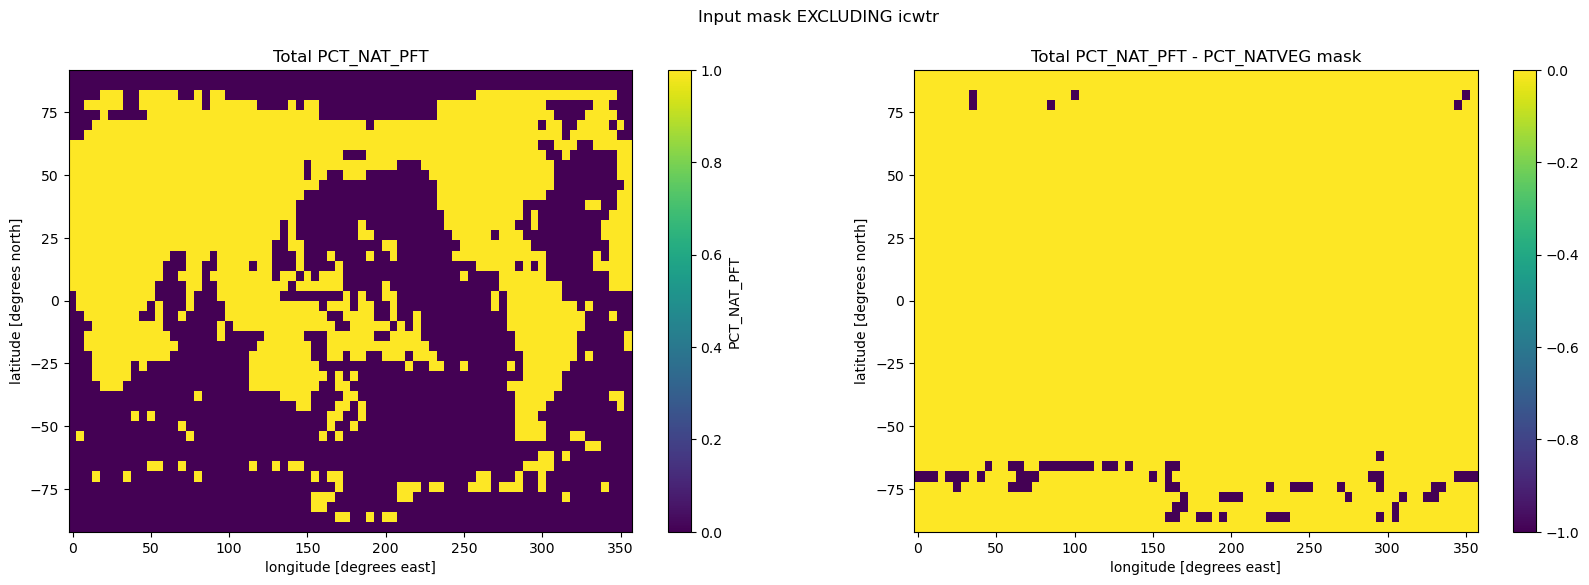

In [27]:
f,ax = plt.subplots(1,2,figsize=(20,6))
ds_regrid_copy.PCT_NAT_PFT.sum(dim='natpft').plot(ax=ax[0])
(ds_regrid_copy.PCT_NAT_PFT.sum(dim='natpft') - xr.where(ds_target.mask,1,0)).plot(ax=ax[1])
ax[0].set_title('Total PCT_NAT_PFT')
ax[1].set_title('Total PCT_NAT_PFT - PCT_NATVEG mask')
f.suptitle('Input mask EXCLUDING icwtr')

Comparing the differences between the plots, it looks like part of the problem is the *inclusion* of the `icwtr` mask for the input mask.

### Primary + Secondary

In [28]:
regridder = xe.Regridder(ds_percent_primary_secondary,ds_target,regrid_method)
ds_regrid = regridder(ds_percent_primary_secondary)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Text(0.5, 0.98, 'Input mask INCLUDING icwtr')

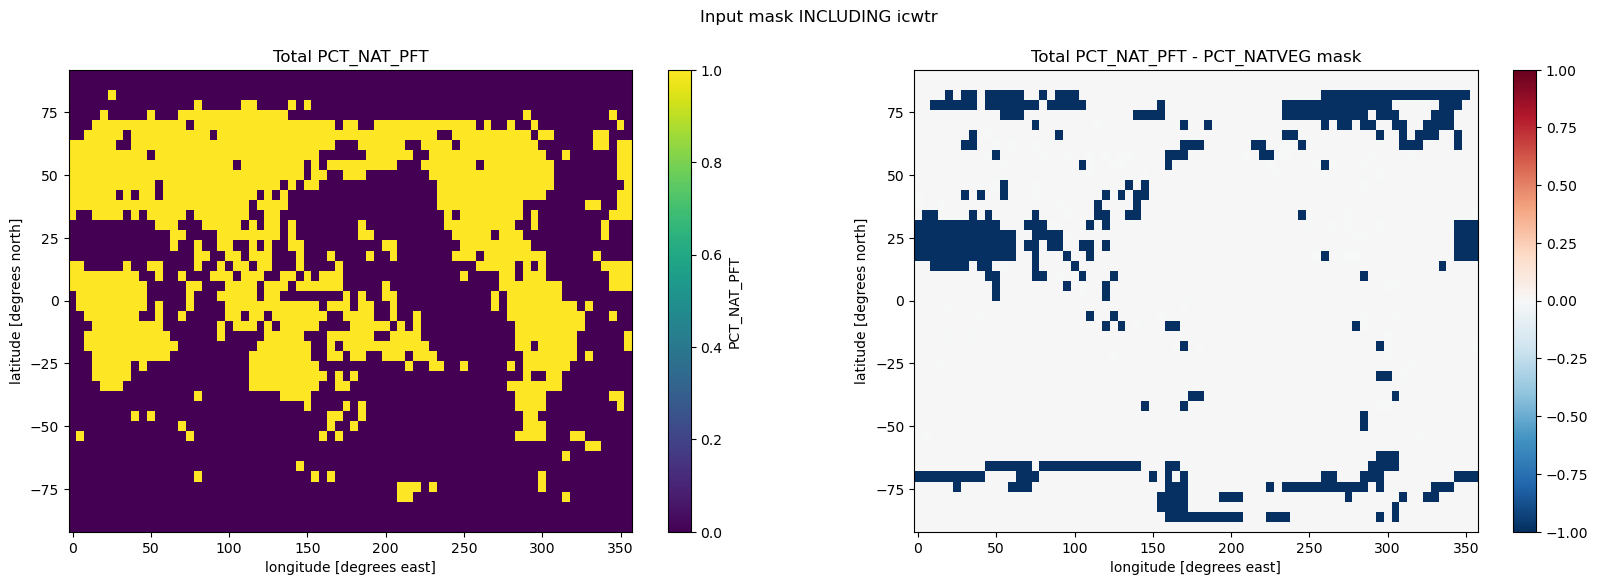

In [29]:
f,ax = plt.subplots(1,2,figsize=(20,6))
ds_regrid.PCT_NAT_PFT.sum(dim='natpft').plot(ax=ax[0])
(ds_regrid.PCT_NAT_PFT.sum(dim='natpft') - xr.where(ds_target.mask,1,0)).plot(ax=ax[1])
ax[0].set_title('Total PCT_NAT_PFT')
ax[1].set_title('Total PCT_NAT_PFT - PCT_NATVEG mask')
f.suptitle('Input mask INCLUDING icwtr')

In [30]:
regridder = xe.Regridder(ds_percent_primary_secondary_copy,ds_target,regrid_method)
ds_regrid_copy = regridder(ds_percent_primary_secondary_copy)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


Text(0.5, 0.98, 'Input mask EXCLUDING icwtr')

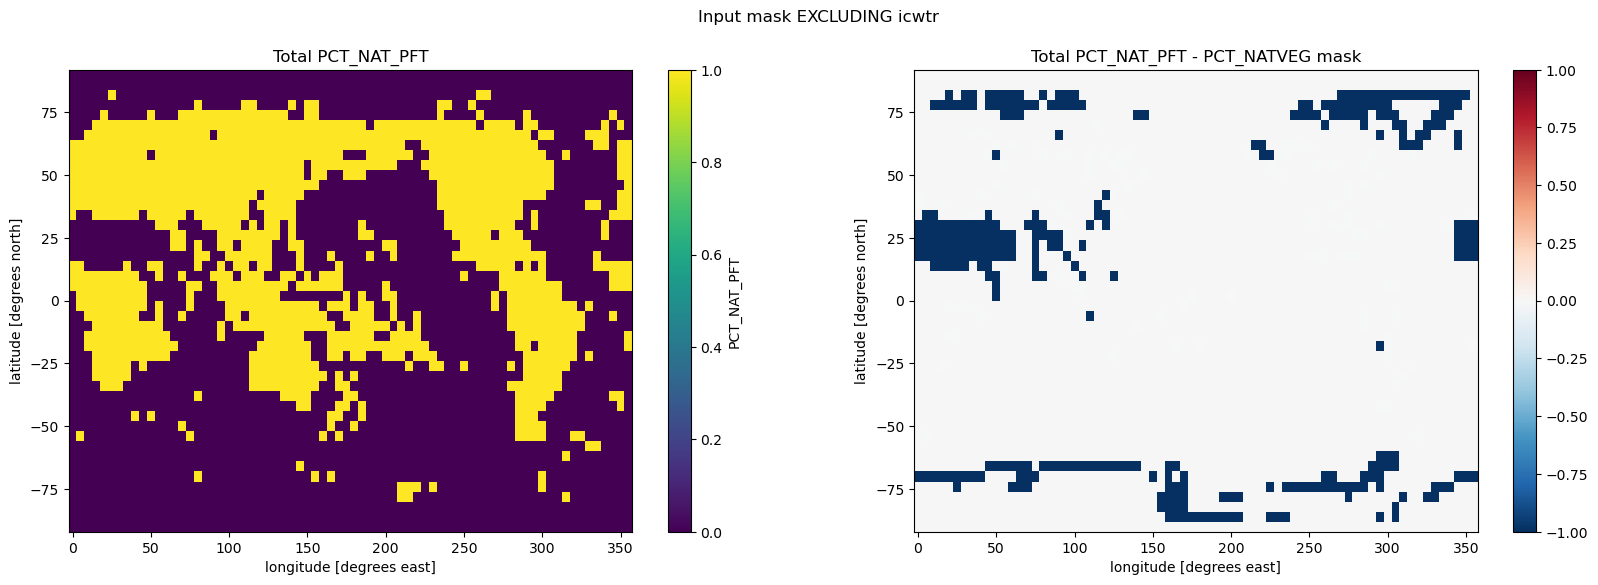

In [31]:
f,ax = plt.subplots(1,2,figsize=(20,6))
ds_regrid_copy.PCT_NAT_PFT.sum(dim='natpft').plot(ax=ax[0])
(ds_regrid_copy.PCT_NAT_PFT.sum(dim='natpft') - xr.where(ds_target.mask,1,0)).plot(ax=ax[1])
ax[0].set_title('Total PCT_NAT_PFT')
ax[1].set_title('Total PCT_NAT_PFT - PCT_NATVEG mask')
f.suptitle('Input mask EXCLUDING icwtr')

As with the pasture dataset, comparing the differences between the plots, it looks like part of the problem is the *inclusion* of the `icwtr` mask for the input mask.  That said, a large issue is that there are areas that are consistentaly not included that are due to the percent primary+secondary data not having any data (North Africa and the middle east).